# Generative adversarial networks. PyTorch

## Контекст


В системе GAN одна из сетей (сеть G, от Generator) генерирует образцы ， а другая (сеть D, от Discriminator) старается отличить правильные («подлинные») образцы от неправильных. Используя набор переменных латентного пространства, генеративная сеть пытается слепить новый образец, смешав несколько исходных образцов. Дискриминативная сеть обучается различать подлинные и поддельные образцы, а результаты различения подаются на вход генеративной сети так, чтобы она смогла подобрать лучший набор латентных параметров, и дискриминативная сеть уже не смогла бы отличить подлинные образцы от поддельных. Таким образом целью сети G является повысить процент ошибок сети D, а целью сети D является наоборот улучшение точности распознавания.

Дискриминационная сеть D, анализируя образцы из оригинальных данных и из подделанных генератором, достигает некоторой точности различения. Генератор при этом начинает со случайных комбинаций параметров латентного пространства , а после оценки полученных образцов сетью D, применяется метод обратного распространения ошибки, который позволяет улучшить качество генерации, подправив входной набор латентных параметров. Постепенно искусственные изображения на выходе генеративной сети становятся всё более качественными. Сеть D реализуется как свёрточная нейронная сеть, в то время как сеть G наоборот разворачивает изображение на базе скрытых параметров.

В процессе совместного конкурентного обучения, если система достаточно сбалансирована, достигается минимаксное состояние равновесия, в котором обе сети значительно улучшили своё качество, и теперь сгенерированные изображения могут быть использованы практически как настоящие.

Идея состязательного обучения была выдвинута в 2013 году Li, Gauci и Gross. Этот метод называется также «обучением Тьюринга», так как ставит целью пройти тест Тьюринга. [источник](https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C)

Нам предстоит обучить и протестировать собственный `GAN`. Обучим `GAN` генерировать лица людей и посмотрим на то, как можно оценивать качество генерации


# Импорт библиотек

Импортируем необходимые для работы в дальнейшем библиотеки. Для удобства соберем импорты в первой ячейке

In [ ]:
%%capture
!pip install catalyst

In [ ]:
import os
import cv2
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import pandas as pd
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from sklearn.preprocessing import QuantileTransformer
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid

from catalyst.utils import set_global_seed
from copy import deepcopy
import matplotlib.pyplot as plt
import warnings
from google.colab.patches import cv2_imshow
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from collections import Counter
%matplotlib inline

sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
np.random.seed(42)
set_global_seed(42)

Загрузим данные

```
Исходник Nvidia Github, часть сета
%%capture
!gdown --id 14C2uQJyifHADPxRUYAvmf4BYKv1-XkQv

Переформатированный источник, уложены под класс imageFolder
%%capture
!gdown --id 1xU6-puCjXuKKJyJdqyUdtC7PM0zRxOr9


```

In [ ]:
%%capture
!gdown --id 1etz8iyzMpgqaXoANWKAOcA1rx77ja3k2

In [ ]:
%%capture
!unzip /content/faces_small_dataset.zip

In [ ]:
%%capture
!gdown --id 1xU6-puCjXuKKJyJdqyUdtC7PM0zRxOr9

In [ ]:
%%capture
!unzip /content/faces_dataset_small.zip

Обозначим устройство

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Часть 1. Подготовка данных

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (`1024х1024`). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing) 
___

 <font size="2"> *примечание* - *был взят сет с оффициального сайта. По ссылке приведенной тут, сет был нерабочий* </font>


Загрузим наши изображения. Сжимать будем до размеров `128` на `128`

In [ ]:
DATA_DIR = '/content/faces_small_dataset'

Использовать будем класс `ImageFolder`, изображения будем приводить к формату 128 на 128, также применим нормализацию, чтобы уравнять наши сети

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose, tt.Resize, tt.CenterCrop
  tt.Normalize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  
  train = ImageFolder(DATA_DIR, 
                      transform=tt.Compose([
                                            
                                tt.Resize(image_size),
                                tt.CenterCrop(image_size),
                                tt.ToTensor(),
                                tt.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))
                                
                                                     ],
                                )
                      )
  train_loader = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_loader

Напишем некоторые вспомогательные функции для работы с изображениями

In [ ]:
def denorm(img_tensors):
    """Функция для нормирования изображения, убирает ошибку при выводе"""
    return img_tensors * .5 + .5


def show_sample(images, nmax=16):
    """Для отображения образца из латентного пространства"""
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))



def show_images(images, nmax=16):
    """Для вывода изображений из загрузчика"""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=4, normalize=True).permute(1, 2, 0))



def show_batch(dataloader, nmax=16, noise=False):

    for images, _ in dataloader:
        if noise:
          images = images.detach().cpu() + .1 * torch.randn(images.size())
          show_images((images), nmax)
        else:
          show_images((images), nmax)
        break


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


def save_samples(index, latent_tensors, show=True, norm=True):
    """Для сохранения образца последней эпохи"""
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    if norm:
      save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=4)
    else:
      save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=4)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

def add_noise(tensor, std = 1., mean = 0., factor=.1):
  """Для добавления шума"""
  return tensor + factor * torch.randn(tensor.size(), device=device) * std + mean


Напишем функцию, которая будет инициализировать весов в наших сверточных и нормализационных слоях

In [ ]:
def weights_init(model_name):
    """Для активации весов"""
    classname = model_name.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model_name.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model_name.weight.data, 1.0, 0.02)
        nn.init.constant_(model_name.bias.data, 0)

Установим размер изображения на `128`, размер батча - `128` изображений

In [ ]:
image_size = 128
batch_size = 128

train_loader = get_dataloader(image_size, batch_size)

Посмотрим на 16 случайных образца выборки. 

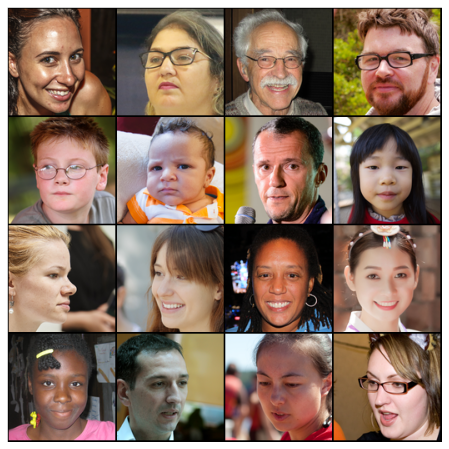

In [ ]:
show_batch(train_loader)

Изображения людей разнообразные, сделаны в различной экпозиции, у людей различные эмоции, есть аксессуары, различается фон, что может мешать нашему `GAN`

## Часть 2. Построение и обучение модели


Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
latent_size = 100

Создадим Дискриминатора на сверточных слоях - важно для даунсэмплинга не использовать `MaxPool` слои - использовать необходимо увеличенный `stride`

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_1 = self.downsampling_(3, 64)
        self.conv_2 = self.downsampling_(64, 128)
        self.conv_3 = self.downsampling_(128, 256)
        self.conv_4 = self.twice_downsampling_(256, 512)
        self.conv_5 = nn.Sequential(

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),

            
            
            )
        self.output = nn.Sequential(
                      nn.Flatten(),
                      nn.Sigmoid()
            
            )
        
    def twice_downsampling_(self, in_chan, out_chan):
        return nn.Sequential(nn.Conv2d(in_chan, out_chan, kernel_size=4, 
                                       stride=4, padding=1),
                             nn.BatchNorm2d(out_chan),
                             nn.LeakyReLU(negative_slope=.2),


        ) 
    def downsampling_(self, in_chan, out_chan):
        return nn.Sequential(nn.Conv2d(in_chan, out_chan, kernel_size=4, 
                                       stride=2, padding=1),
                             nn.BatchNorm2d(out_chan),
                             nn.LeakyReLU(negative_slope=.2)
        ) 
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.output(x)
        return x

Теперь - Генератор, который из шума будет создавать изображения

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()


        self.conv_1 = nn.Sequential(nn.ConvTranspose2d(latent_size, 512, 
                                                       kernel_size=4, 
                                                       stride=1, 
                                                       padding=0),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(),
                      )
        self.conv_2 = self.twice_upsampling_(512, 256)
        self.conv_3 = self.upsampling_(256, 128)
        self.conv_4 = self.upsampling_(128, 64)
        self.conv_5 = nn.Sequential(nn.ConvTranspose2d(64, 3, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1),
                                    nn.Tanh()
                  )
        

    def twice_upsampling_(self, in_chan, out_chan):
        return nn.Sequential(nn.ConvTranspose2d(in_chan, in_chan, 
                                                       kernel_size=4, 
                                                       stride=2, 
                                                       padding=1),
                             nn.BatchNorm2d(in_chan),
                             nn.ReLU(),
                             nn.ConvTranspose2d(in_chan, out_chan, 
                                                       kernel_size=4, 
                                                       stride=2, 
                                                       padding=1),
                            nn.BatchNorm2d(out_chan),
                            nn.ReLU(),

                      )
    def upsampling_(self, in_chan, out_chan):
        return nn.Sequential(nn.ConvTranspose2d(in_chan, out_chan, 
                                                       kernel_size=4, 
                                                       stride=2, 
                                                       padding=1),
                             nn.BatchNorm2d(out_chan),
                             nn.ReLU()

                      )
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        return x

Перейдем теперь к обучению нашего `GAN`. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1 (реализуем логику, где будем показывать метку .9)
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
discriminator = to_device(Discriminator(), device)
generator = Generator()

Посмотрим, правильно ли работает наш генератор - на выходе должны получать изображение `3 * 128 * 128`

In [ ]:
%%capture
discriminator.apply(weights_init)

Размер тензора: torch.Size([128, 3, 128, 128])


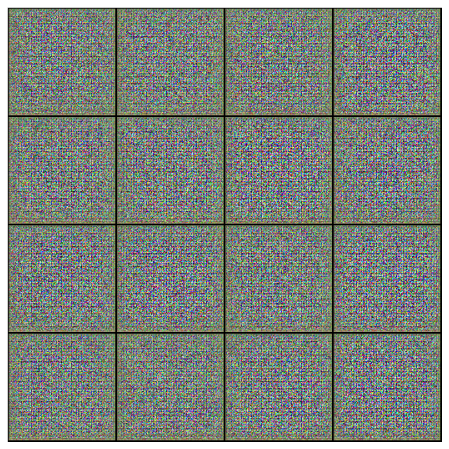

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(f'Размер тензора: {fake_images.shape}')
show_sample(fake_images)

На выходе получили изображения, 128 на 128 с 3 каналами, как задумано - исходные изображения обучающей выборки также представлены в аналогичном размере

In [ ]:
generator = to_device(generator, device)

Инициализируем веса в слоях у генератора. Ранее сделали также у дискриминатора

In [ ]:
%%capture
generator.apply(weights_init)

Зададим параметры обучения

In [ ]:
epochs = 25
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)
lr = 2e-4

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

Будем угнетать дискриминатор. Вместо `1` - подавать `0.9` на вход как таргет для реальных значений [источник](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b). Это позволит сдерживать лосс Дискриминатора, что позволит Генератору лучше разиваться

```
Реализация в TensorFlow 2 (для 10 классов, как пример)

p = tf.placeholder(tf.float32, shape=[None, 10])
feed_dict = {
  p: [[0, 0, 0, 0.9, 0, 0, 0, 0, 0, 0]]
}
d_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=p, logits=logits_real_image)

```

Реализуем логику на `torch`

In [ ]:
dtype = torch.cuda.FloatTensor
def ones_target(size):
    """Вместо 1 в качестве таргета применим одностороннее сглаживание и поставим таргет 0,9
       # real_targets = torch.ones(real_images.size(0), 1, device=device)"""
    targets = Variable(torch.Tensor(size, 1).fill_(.9).type(dtype))
    return targets

Также, добавим немного шума - как на реальные изображения, так и искусственные - это поможет нашим моделям лучше конкурировать, перед тем, как показать их дискриминатору. `scale` установлен на `.1` - шум незначительный, но также это положительно скажется на развитии Генератора на первых эпохаха

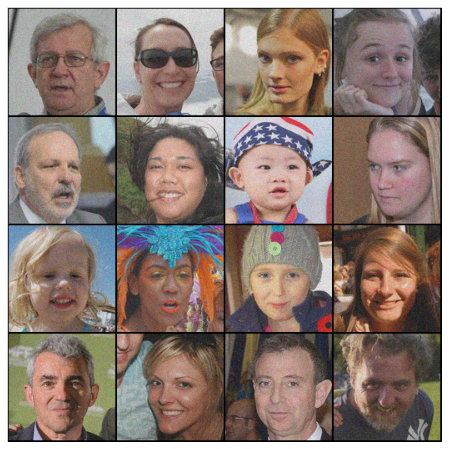

In [ ]:
show_batch(train_loader, noise=True)

Качество не сильно упало, но данный трюк поможет нашим моделям соревноваться

Напишем функцию обучения. На выходе будем получать историю обучения и образцы генерируемых изображений - на данном этапе, качество будем контролировать визуально

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1, verbose=1):
    model["discriminator"].train()
    model["generator"].train()
    with torch.no_grad():
      torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(.5, .999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(.5, .999))
    }
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      for epoch in range(epochs):
          loss_d_per_epoch = []
          loss_g_per_epoch = []
          real_score_per_epoch = []
          fake_score_per_epoch = []
          for real_images, _ in train_loader:
              # Учим дискриминатор

              optimizer["discriminator"].zero_grad()

              # Пропускаем реальные изображения через дискриминатор
              real_images = real_images.to(device)
              nums = real_images.size(0)
              real_images = add_noise(real_images)
              real_preds = model["discriminator"](real_images)
              
              
              # в качестве реального таргета - .9 вместо 1.0
              real_targets = ones_target(nums).to(device)
              real_loss = criterion["discriminator"](real_preds, real_targets)
              cur_real_score = torch.mean(real_preds).item()
              
              # Создаем искусственные изображения
              latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
              fake_images = model["generator"](latent)
              fake_images = add_noise(fake_images)
              # Пропускаем искусственные изображения через дискриминатор

              fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
              fake_preds = model["discriminator"](fake_images)
              fake_loss = criterion["discriminator"](fake_preds, fake_targets)
              cur_fake_score = torch.mean(fake_preds).item()

              real_score_per_epoch.append(cur_real_score)
              fake_score_per_epoch.append(cur_fake_score)

              # Обновляем веса дискриминатора
              loss_d = real_loss + fake_loss
              loss_d.backward()
              optimizer["discriminator"].step()
              loss_d_per_epoch.append(loss_d.item())

              # Учим генератор

              optimizer["generator"].zero_grad()
              
              # Создаем искусственные изображения
              latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
              fake_images = model["generator"](latent)
              fake_images = add_noise(fake_images)
              # Пытаемся показать их дискриминатору как реальные
              preds = model["discriminator"](fake_images)
              targets = torch.ones(batch_size, 1, device=device)
              loss_g = criterion["generator"](preds, targets)
              
              # Обновляем веса генератора
              loss_g.backward()
              optimizer["generator"].step()
              loss_g_per_epoch.append(loss_g.item())
              

          losses_g.append(np.mean(loss_g_per_epoch))
          losses_d.append(np.mean(loss_d_per_epoch))
          real_scores.append(np.mean(real_score_per_epoch))
          fake_scores.append(np.mean(fake_score_per_epoch))
          pbar_outer.update(1)
          
          if (epoch + 1) % verbose == 0 or epoch == (epochs - 1):
            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, epochs, 
                losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
      
    
          if (epoch + 1) % 10 == 0 or epoch == (epochs - 1):
            save_samples(epoch + start_idx, fixed_latent, show=False, norm=True)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(model, criterion, epochs, lr, verbose=1)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 6.5287, loss_d: 0.9169, real_score: 0.7433, fake_score: 0.1674
Epoch [2/25], loss_g: 3.7137, loss_d: 0.8973, real_score: 0.6903, fake_score: 0.2055
Epoch [3/25], loss_g: 3.4835, loss_d: 0.9893, real_score: 0.6471, fake_score: 0.2483
Epoch [4/25], loss_g: 3.2441, loss_d: 0.9989, real_score: 0.6388, fake_score: 0.2569
Epoch [5/25], loss_g: 3.1245, loss_d: 0.9438, real_score: 0.6530, fake_score: 0.2435
Epoch [6/25], loss_g: 3.2245, loss_d: 0.8994, real_score: 0.6700, fake_score: 0.2277
Epoch [7/25], loss_g: 2.9981, loss_d: 0.9419, real_score: 0.6541, fake_score: 0.2443
Epoch [8/25], loss_g: 2.7708, loss_d: 0.9504, real_score: 0.6497, fake_score: 0.2493
Epoch [9/25], loss_g: 2.6764, loss_d: 0.9530, real_score: 0.6458, fake_score: 0.2524
Epoch [10/25], loss_g: 2.6218, loss_d: 0.9302, real_score: 0.6517, fake_score: 0.2468
Saving generated-images-0010.png
Epoch [11/25], loss_g: 2.4776, loss_d: 0.9477, real_score: 0.6444, fake_score: 0.2544
Epoch [12/25], loss_g: 2.3020,

Посмотрим изображения 20 эпохи - с которой Дискриминатор стал наращивать скор, и на последней - 25 эпохе

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-0020.png')
generated_img = generated_img[:, :, [2, 1, 0]]

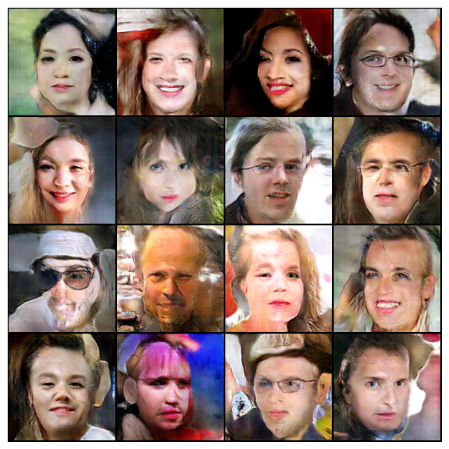

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)
plt.show()

Есть множество артефактов и сюрреализма, но в целом - результаты лучше, чем были ранее

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-0025.png')
generated_img = generated_img[:, :, [2, 1, 0]]

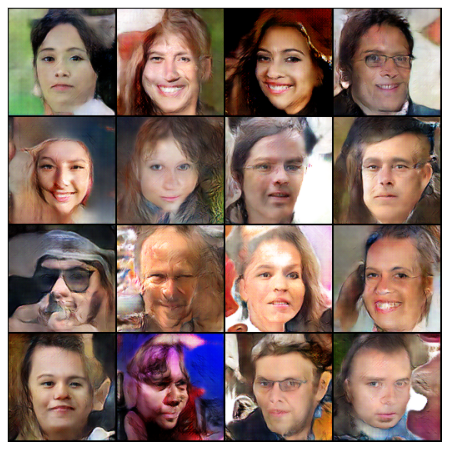

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)
plt.show()

Как отмечалось выше - результаты лучше, чем ранее, для такой простой архитектуры

Построим графики лосса для генератора и дискриминатора.  Но перед этим - сохраним наши модели. Стоит отметить, что Дискриминатор старается свести скор к `1` от `.5`, а Генератор - от `0` до `.5`. Модель перестает обучаться в тот момент, когда Генератор больше не способен обмануть Дискриминатор и скор Дискриминатора начинается подниматься. Скор Дискриминатора немного снижен - мы передавали `.9` вместо `1` 

In [ ]:
torch.save(generator.state_dict(), 'Generator_smooth_100_norm_and_noise')
torch.save(discriminator.state_dict(), 'Discriminator_smooth_100_norm_and_noise')

In [ ]:
%%capture
!gdown --id 1K2Tr9EyX39f3unoKzdvVD6K2NkHDZkSO
!gdown --id 1XnIyFnc3zu-XyoCophRxK8najRCF2c8J


discriminator =  to_device(Discriminator(), device)
discriminator.load_state_dict(torch.load('Discriminator_smooth_100_norm_and_noise'))

generator =  to_device(Generator(), device)
generator.load_state_dict(torch.load('/content/Generator_smooth_100_norm_and_noise'))

Код для загрузки различных моделей, обученных на первичном датасете с `1000` изображениями - получили достаточно низкое качество на старом сете. Новая модель обучена на сете с источника. Пробовали различные комбинации слоев и гиперпараметров, в том числе увеличивали количество эпох до 300. Все модели сохранены для тестирования. Выше сохранена модель обученная на более обширном сете данных, что позволило достичь более хорошего качества для такой простой архитектуры:

<a id=up></a>

```

Для загрузки моделей других моделей:
_____________________________________________________________________

1. Латентное пространство 64, 50 epochs

%%capture
!gdown --id 14i4KUCSsHU2mehbBibxJU6mNybxiMmbS
!gdown --id 1qSMC-wZ_d6jSqRt4elMihw1cvgiNEK-y


discriminator =  to_device(Discriminator(), device)
discriminator.load_state_dict(torch.load('/content/Discriminator'))

generator =  to_device(Generator(), device)
generator.load_state_dict(torch.load('/content/Generator'))


2. Латентное пространство 128, 50 epochs


%%capture
!gdown --id 1NZ4jZoVPc_EUF1hEBrSbYtU1wKM95T8L
!gdown --id 1sN02kHeuTue-esiXfc4KO9jhZGvwRd5i


discriminator =  to_device(Discriminator(), device)
discriminator.load_state_dict(torch.load('/content/Discriminator_128'))

generator =  to_device(Generator(), device)
generator.load_state_dict(torch.load('/content/Generator_128'))


3. Латентное пространство 32 with _smooth and 80 epochs

%%capture
!gdown --id 1DsWPzecfOmKjEgLYu7xFDS3YShzFfpX5
!gdown --id 1s8RdEmK6uf8ikJQragy9dOO8hzbdWx0j


discriminator =  to_device(Discriminator(), device)
discriminator.load_state_dict(torch.load('/content/Discriminator_smooth'))

generator =  to_device(Generator(), device)
generator.load_state_dict(torch.load('/content/Generator_smooth'))

4. Латентное пространство 32 with _smooth and 180 epochs

%%capture
!gdown --id 1y_VqEeHlWNytSlOmw_EZGH8bauQd8-tm
!gdown --id 1p-qD4y0bsBtiwY80Tvj7Q2dfVN7lA2TB


discriminator =  to_device(Discriminator(), device)
discriminator.load_state_dict(torch.load('/content/Discriminator_smooth_180'))

generator =  to_device(Generator(), device)
generator.load_state_dict(torch.load('/content/Generator_smooth_180'))


5. Латентное 256 и 300 epoch

%%capture
!gdown --id 1PeXHnXW5QtxZosf-H4EX9ZAk4Z83tJTz
!gdown --id 1E6f7sp8vJcY6RzfL_IdMp6LTe7UtTUqF

discriminator =  to_device(Discriminator(), device)
discriminator.load_state_dict(torch.load('/content/Discriminator_smooth_256'))

generator =  to_device(Generator(), device)
generator.load_state_dict(torch.load('/content/Generator_smooth_256'))


```

Загрузим историю в переменные

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Посмотрим, как обучались наши модели. Напомню, что `lr = 2e-4`, `25 эпох`, `batch_size = 128`, `latent = 100`, расширенный датасет. Использовалось сглаживание одностороннее таргета для дискриминатора и добавлен шум нормальнораспределенный:

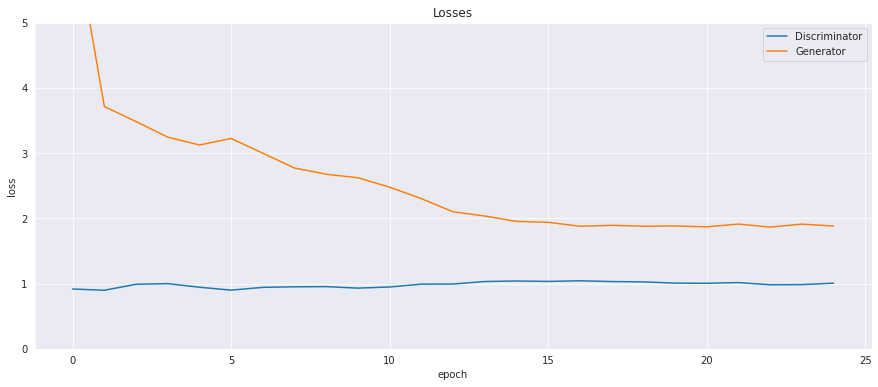

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylim([0, 5])
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Как видим, в процессе обучения Генератор старается снизить Лосс, как и дискриминатор - что позволяет модели обучаться - Генератор старается побороть Дискриминатора

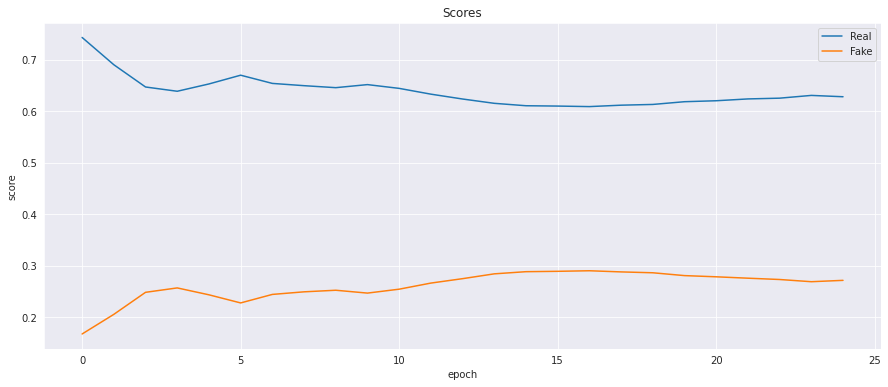

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Значения скора Дискриминатора будет варьироватьсяна отрезке `[.5, 1]` .у Генератора - `[0, .5]` - в тот момент, когда Дискриминатор начинает увеличивать свой скор до 1, а скор Генератора стремиться к 0 - GAN перестает учиться

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений визуально. Напомню, что мы использовали технику подавления дискриминатора через одностороннее сглаживание и добавление небольшого шума на изображения (`factor=.1`)

In [ ]:
n_images = 16

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

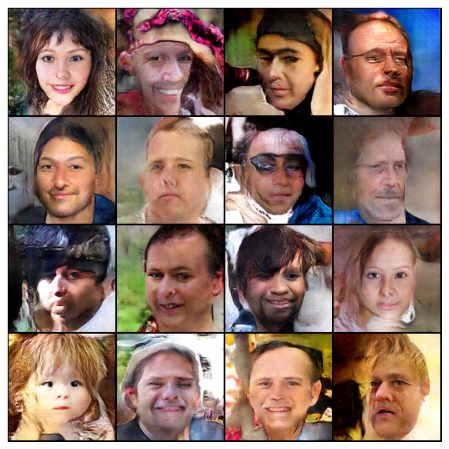

In [ ]:
show_images(fake_images.cpu())

Первое изображение - достаточно удачное. Есть сюрреализмы, искажения и артефакты - но в целом - достаточно неплохо для простой архитектуры. Ниже представлены варианты иных подходов для примера и сравнения качества

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

Ниже также приведеные иные результаты (с различными параметрами) на уменьшенном сете. Данные изображения были получены при исследовании различных подходов в работе с `vanilla GAN`. Коды загрузки моделей приведены [выше](#up)

Качество достаточно неправдоподобное, но похоже на фото с обработкой в виде пастели. Есть множество артефактов. Это можно объяснить достаточно маленьким сетом и не сложной архитектурой сети, при этом наш трюк с односторонним сглаживанием - достаточно сильно помог нам в качестве - без него - изображения были очень неприемлемого качества

## Часть 4. Leave-one-out-1-NN classifier accuracy

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы, реализуем следующий подхож:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

### 4.1. Подсчет accuracy

Загрузим наши данные. Возьмем уменьшенный сет на 1000 образцов изображений

In [ ]:
DATA_DIR = '/content/faces_dataset_small'

Загрузим наши ранее обученные модели

In [ ]:
%%capture
!gdown --id 1K2Tr9EyX39f3unoKzdvVD6K2NkHDZkSO
!gdown --id 1XnIyFnc3zu-XyoCophRxK8najRCF2c8J

discriminator =  to_device(Discriminator(), device)
discriminator.load_state_dict(torch.load('Discriminator_smooth_100_norm_and_noise'))

generator =  to_device(Generator(), device)
generator.load_state_dict(torch.load('/content/Generator_smooth_100_norm_and_noise'))

Подготовим функцию, которая будет создавать из изображения `DataFrame` с метками. 

In [ ]:
def get_flatten(image_size, loader='train'):
  """
  Функция переводит изображения в DataFrame
  Далее создает ненастоящие ищображения и также добавляет
  их в DF. У настоящих метка 1, у ненастоящих 0
  """
  # здесь переводит изображения из папки в DF настоящие и присваиваем метку 1
  
  train = ImageFolder(DATA_DIR, 
                      transform=tt.Compose([
                                            
                                tt.Resize(image_size),
                                tt.CenterCrop(image_size),
                                tt.ToTensor(),
                                tt.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))
                                
                                                     ],
                                )
                      )
  
  train_loader = DataLoader(train, 1, shuffle=True, num_workers=2, pin_memory=True)
  table = []
  print('Работаю с реальными изображениями. Метка 1')
  for batch, _ in tqdm(train_loader):
    batch = batch.permute(0, 2, 3, 1).flatten().cpu().numpy()
    sample = {f"pix_{i}": pix for i, pix in enumerate(batch)}
    sample['label'] = 1
    table.append(sample)

  # здесь генерируем ненастоящие изображения и даем им метку 0

  print('Работаю с искусственными изображениями. Метка 0')
  for i in tqdm(range(len(train_loader))):
    fixed_latent = torch.randn(1, 100, 1, 1, device=device)
    fake_images = generator(fixed_latent)
    fake_images = fake_images.detach().permute(0, 2, 3, 1).flatten().cpu().numpy()
    sample = {f"pix_{i}": pix for i, pix in enumerate(fake_images)}
    sample['label'] = 0
    table.append(sample)

  # создаем DF и перемешиваем

  table = pd.DataFrame(table)
  table['label'] = table['label'].astype(str)
  table = shuffle(table, random_state=42)
  print("Завершено. Данные созданы")
  return table 

Эта функция будет проверять, корректность созданной таблицы. Переводить изображения из таблицы в изображения `128*128*3`

In [ ]:
def check_img(data):
  """
  Функция для проверки корректности формирования сета
  На выходе из таблицы выдает изображение
  """

  features = data.drop('label', axis=1)
  feat = shuffle(features, random_state=42)
  X_ = np.array(feat)
  X_t = X_.reshape(X_.shape[0], 128, 128, 3)


  fig = plt.figure(figsize=(8,8))

  for i in range(16):
      fig.add_subplot(4, 4, i+1)
      plt.imshow(np.clip((X_t[i] *.5 + .5), 0, 1))
      plt.xticks([])
      plt.yticks([])
      plt.tight_layout()

In [ ]:
image_size = 128
batch_size = 128

train_loader = get_dataloader(image_size, batch_size)

Посмотрим образец из исходного сета

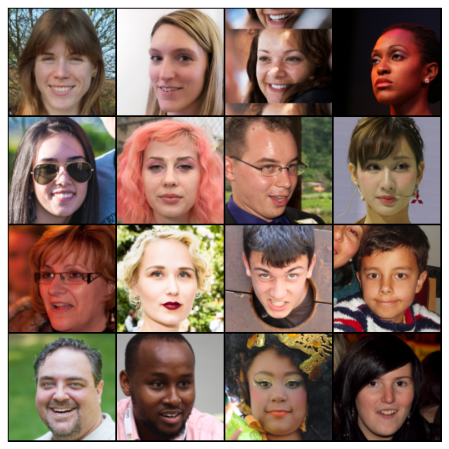

In [ ]:
show_batch(train_loader)

Теперь можем создать сет. Он сразу будет в себе содержать и искусственные и реальные изображения, перемешанный, чтобы классы не шли друг за другом в виде `union-сета`

In [ ]:
X_train = get_flatten(image_size)

Работаю с реальными изображениями. Метка 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Работаю с искусственными изображениями. Метка 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Завершено. Данные созданы


In [ ]:
X_train.head()

pix_0     pix_1     pix_2  ...  pix_49150  pix_49151  label
1860  0.634240 -0.216644 -0.389656  ...   0.122232   0.090292      0
353  -0.772549 -0.890196 -0.992157  ...  -0.419608  -0.552941      1
1333 -0.894964 -0.736988 -0.859743  ...   0.783414   0.754804      0
905   0.945098  0.631373  0.349020  ...   0.443137   0.058824      1
1289 -0.223286 -0.056845  0.006691  ...  -0.588284  -0.202398      0

[5 rows x 49153 columns]

Сохраним таблицу - если потребуется перезапуск, чтобы не генерировать новую

In [ ]:
X_train.to_csv('X_train.csv', index=False)

```
%%capture
!gdown --id 1ljIWzeTd4xNRxlkXEo3iJSae97SaMtoS
X_train = pd.read_csv('/content/X_train.csv')
```

In [ ]:
print(f'Количество пикселей на одно изображение {X_train.shape[1]}. Размер 128х128х3')
print(f'Количество изображений {X_train.shape[0]}')

print('Баланс меток')
X_train['label'].value_counts(normalize=True)

Количество пикселей на одно изображение 49153. Размер 128х128х3
Количество изображений 2000


1    0.5
0    0.5
Name: label, dtype: float64

Проверим наш сет. Обратите внимание, что он перемешен - это сделано специально, чтобы метки 1 и 0 не шли друг за другом последовательно. Посмотрим на изображения в таблице `X_train`

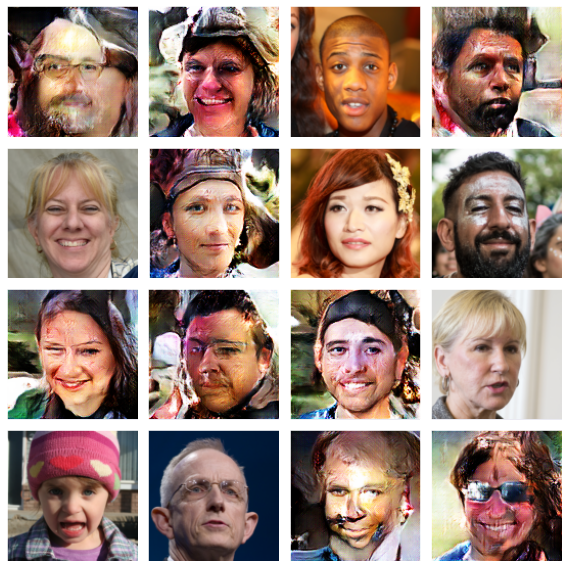

In [ ]:
check_img(X_train)

Сет представлен изображениями как реальными, так и искусственными. Визуально, претензии к искусственным  есть. Посмотрим, что скажет классификатор. В идеале - значение Accuracy как можно ближе должно быть к 50%

In [ ]:
loo = LeaveOneOut()
neigh = KNeighborsClassifier(n_neighbors=1)

X = X_train.drop('label', axis=1)
y = X_train[['label']]

Теперь рассчитаем `Accuracy` - сделаем `2000` разделений (по количеству изображений) - потом посчитаем среднее значение для метрики

In [ ]:
y_true, y_pred = list(), list()

with tqdm(desc="Итерация", total=X_train.shape[0]) as pbar_outer:
  
  for idx, (train_idx, test_idx) in enumerate(loo.split(X)):

    train_X, test_X = X.loc[train_idx], X.loc[test_idx]
    train_y, test_y = y.loc[train_idx], y.loc[test_idx]
    

    neigh.fit(train_X, train_y)
    y_preds = neigh.predict(test_X)
    

    y_true.append(np.array(test_y)[0][0])
    y_pred.append(y_preds[0])
    pbar_outer.update(1)

acc = accuracy_score(y_true, y_pred)
print('Accuracy для наших признаков: %.3f' % acc)

Итерация:   0%|          | 0/2000 [00:00<?, ?it/s]

Accuracy для наших признаков: 0.610


В идеальном случае - `Accuracy` будет равно `.5` (`50%`) - модель не может точно определить класс, присутствует случайность, это говорит нам о том, что сгенерированные изображения достаточно похожи на реальные и имеют схожие признаки. Чем ближе к `100%` наша точность - тем хуже наш Генератор создает изображения. Мы получили `0.61` - достаточно хороший результат

### 4.2. Визуализация распределений

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуемся `t_SNE`-методом, снижающим размерность и изобразим на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи. Сжимать будем до 2 компонент

In [ ]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)

In [ ]:
y['text_label'] = np.where(y['label'] == '1', 'Реальное', 'Искусственное')

In [ ]:
fig = px.scatter(X_embedded, x = 0, y = 1, 
           color=y['text_label'], opacity=0.84,
           
                 labels={
                     'color': "Класс "
                 },
                title="Отображение распределений признаков по классам с t-SNE")\
                .for_each_trace(lambda t: t.update(name=t.name.replace("=",": "))
                )
           
           

fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                selector=dict(mode='markers'))
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(visible=False, showticklabels=False)
fig.show();

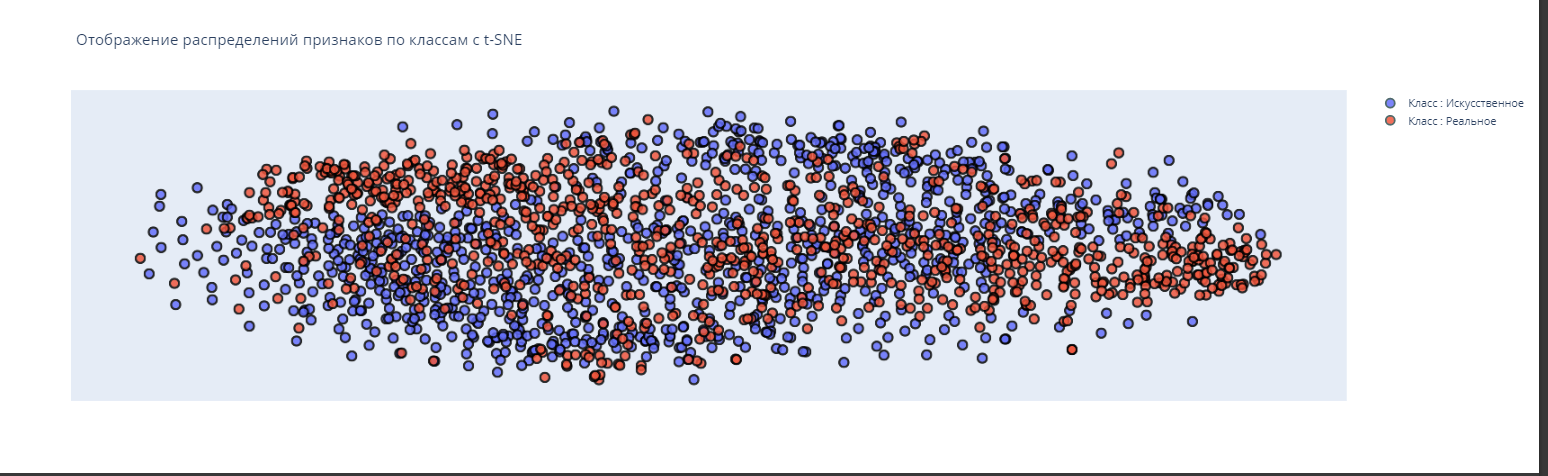

Отлично. Точки не могут быть отделены, все находятся вперемешку, не разделены - это свидетельствует нам о том, что генератор неплохо справляется с задачей - признаки изображений искусственных - достаточно близки к тем, что были в реальном сете. Наши выводы подтверждаются - генератор достаточно хорошо генерирует изображения